In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tifffile as tiff

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import numpy as np

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import random
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [5]:
def stretch_n(img, lower_percent=5, higher_percent=95):    
    '''
    adjusting the contrast of images and getting values in a range
    '''
    # https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(img, dtype=np.float32)
    n = img.shape[2]
    for i in range(n):
        a = 0       # np.min(img)
        b = 1       # np.max(img)
        c = np.percentile(img[:, :, i], lower_percent)
        d = np.percentile(img[:, :, i], higher_percent)
        t = a + (img[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)

In [6]:
x_final = np.load('data/all_images.npy')
y_final = np.load('data/all_masks.npy')
x_final.shape,y_final.shape

((3600, 8, 160, 160), (3600, 10, 160, 160))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

In [8]:
del x_final
del y_final

# Training unet

In [9]:
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [10]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [16]:
def get_unet():
    ISZ = 160
    inputs = Input((8, ISZ, ISZ))
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(10, 1, activation='sigmoid')(conv9)

    model = Model(inputs,conv10)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[jaccard_coef, 'accuracy'])
    return model

In [17]:
model = get_unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 8, 160, 160)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 160, 160) 2336        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 160, 160) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 80, 80)   0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [18]:
model.fit(X_train, y_train, batch_size=8, epochs=100, shuffle=True,validation_data=(X_test, y_test)) # fit model

Train on 3240 samples, validate on 360 samples
Epoch 1/100
3240/3240 [==============================] - 124s 38ms/step - loss: 0.1810 - jaccard_coef: 0.1715 - accuracy: 0.9373 - val_loss: 0.1434 - val_jaccard_coef: 0.2259 - val_accuracy: 0.9505
Epoch 2/100
3240/3240 [==============================] - 201s 62ms/step - loss: 0.1312 - jaccard_coef: 0.2441 - accuracy: 0.9521 - val_loss: 0.1158 - val_jaccard_coef: 0.2756 - val_accuracy: 0.9596
Epoch 3/100
3240/3240 [==============================] - 248s 76ms/step - loss: 0.1058 - jaccard_coef: 0.3168 - accuracy: 0.9642 - val_loss: 0.0917 - val_jaccard_coef: 0.3360 - val_accuracy: 0.9692
Epoch 4/100
3240/3240 [==============================] - 238s 73ms/step - loss: 0.0908 - jaccard_coef: 0.3433 - accuracy: 0.9692 - val_loss: 0.0847 - val_jaccard_coef: 0.3711 - val_accuracy: 0.9711
Epoch 5/100
3240/3240 [==============================] - 269s 83ms/step - loss: 0.0794 - jaccard_coef: 0.3711 - accuracy: 0.9728 - val_loss: 0.0735 - val_jaccard

Epoch 42/100
3240/3240 [==============================] - 126s 39ms/step - loss: 0.0243 - jaccard_coef: 0.6469 - accuracy: 0.9900 - val_loss: 0.0295 - val_jaccard_coef: 0.5980 - val_accuracy: 0.9887
Epoch 43/100
3240/3240 [==============================] - 135s 42ms/step - loss: 0.0242 - jaccard_coef: 0.6435 - accuracy: 0.9900 - val_loss: 0.0289 - val_jaccard_coef: 0.6047 - val_accuracy: 0.9889
Epoch 44/100
3240/3240 [==============================] - 127s 39ms/step - loss: 0.0236 - jaccard_coef: 0.6571 - accuracy: 0.9902 - val_loss: 0.0282 - val_jaccard_coef: 0.6084 - val_accuracy: 0.9891
Epoch 45/100
3240/3240 [==============================] - 128s 40ms/step - loss: 0.0232 - jaccard_coef: 0.6550 - accuracy: 0.9904 - val_loss: 0.0290 - val_jaccard_coef: 0.6006 - val_accuracy: 0.9889
Epoch 46/100
3240/3240 [==============================] - 129s 40ms/step - loss: 0.0232 - jaccard_coef: 0.6551 - accuracy: 0.9904 - val_loss: 0.0280 - val_jaccard_coef: 0.6050 - val_accuracy: 0.9892
Epoch

In [20]:
from sklearn.metrics import jaccard_score

N_Cls = 10

prd = model.predict(X_test)

avg, trs = [], []

for i in range(N_Cls): #going through each class
    t_msk = y_test[:, i, :, :]
    t_prd = prd[:, i, :, :]
    
    #reshaping to 2D
    t_msk = t_msk.reshape(y_test.shape[0] * y_test.shape[2], y_test.shape[3])
    t_prd = t_prd.reshape(y_test.shape[0] * y_test.shape[2], y_test.shape[3])

    max_jk, b_tr = 0, 0
    for j in range(10):  
        tr = j / 10.0   #threshold of [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        pred_mask_threshold = t_prd > tr #creating binary from threshold
        js = jaccard_score(t_msk, pred_mask_threshold,average = 'micro') # calculate jaccard similarity for predict mask and actual mask
        if js > max_jk:  
            max_jk = js
            b_tr = tr  #storing threshold of max jaccard score
    print('Max jaccard score for class ',i+1,' is ', round(max_jk,2),' and its threshold is ',b_tr)
    avg.append(round(max_jk,2))
    trs.append(b_tr)

score = sum(avg) / 10.0
print('Overall jaccard score is ',round(score,2))

Max jaccard score for class  1  is  0.76  and its threshold is  0.4
Max jaccard score for class  2  is  0.37  and its threshold is  0.3
Max jaccard score for class  3  is  0.91  and its threshold is  0.4
Max jaccard score for class  4  is  0.62  and its threshold is  0.4
Max jaccard score for class  5  is  0.78  and its threshold is  0.4
Max jaccard score for class  6  is  0.98  and its threshold is  0.6
Max jaccard score for class  7  is  0.88  and its threshold is  0.6
Max jaccard score for class  8  is  0.85  and its threshold is  0.5
Max jaccard score for class  9  is  0.25  and its threshold is  0.1
Max jaccard score for class  10  is  0.26  and its threshold is  0.2
Overall jaccard score is  0.67


In [21]:
trs #thresholds

[0.4, 0.3, 0.4, 0.4, 0.4, 0.6, 0.6, 0.5, 0.1, 0.2]

In [22]:
model.save('unet_model.h5')

## Prediction of U_Net Model

In [23]:
def band_8(image_id):
    '''
    getting 8 band images i.e M Bands
    '''
    filename = "sixteen_band/{}_M.tif".format(image_id)
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img

In [24]:
img_test = band_8('6120_2_0') #Random Image
img_test.shape

(837, 851, 8)

In [26]:
from patchify import patchify
mask = tiff.imread('masks/6120_2_0.tif')

In [27]:
patch_maskid = patchify(mask,(160,160,10),step=160)
patch_maskid = patch_maskid[:,:,0,:,:,:]
patch_maskid.shape

(5, 5, 160, 160, 10)

In [28]:
from patchify import patchify
img = stretch_n(img_test)
patch_imgid = patchify(img,(160,160,8),step=160)

In [29]:
patch_imgid = patch_imgid[:,:,0,:,:,:]
patch_imgid.shape

(5, 5, 160, 160, 8)

In [30]:
patch_images = np.zeros((patch_imgid.shape[0]*patch_imgid.shape[1], 160, 160,8))
patch_mask = np.zeros((patch_imgid.shape[0]*patch_imgid.shape[1], 160, 160,10))
c = 0
for i in range(patch_imgid.shape[0]):
    for j in range(patch_imgid.shape[1]):
        #structuring for prediction
        patch_images[c,:,:,:] = patch_imgid[i,j,:,:,:]
        patch_mask[c,:,:,:] = patch_maskid[i,j,:,:,:]
        c+=1

In [31]:
patch_images.shape

(25, 160, 160, 8)

In [32]:
patch_images = 2 * np.transpose(patch_images, (0, 3, 1, 2)) - 1
patch_images.shape

(25, 8, 160, 160)

In [33]:
pred_mask = model.predict(patch_images)
pred_mask.shape

(25, 10, 160, 160)

In [34]:
pred_mask = np.transpose(pred_mask,(0, 2,3,1)) #converting first channel to last channel for visualisation
pred_mask.shape

(25, 160, 160, 10)

In [35]:
patch_images = np.transpose(patch_images,(0, 2,3,1)) #converting first channel to last channel for visualisation
patch_images.shape

(25, 160, 160, 8)

In [36]:
#with given threshold. assigning 0 and 1
for i in range(len(pred_mask)):
    for j in range(10):
        pred_mask[i,j,:,:] = pred_mask[i,j,:,:]>trs[j]

## Patching all the Images

In [37]:
#from kaggle
classes = ['Buildings',
            'Misc.',
            'Road',
            'Track',
            'Trees',
            'Crops',
            'Waterway', 
            'Standing water',
            'Vehicle Large',
            'Vehicle Small']

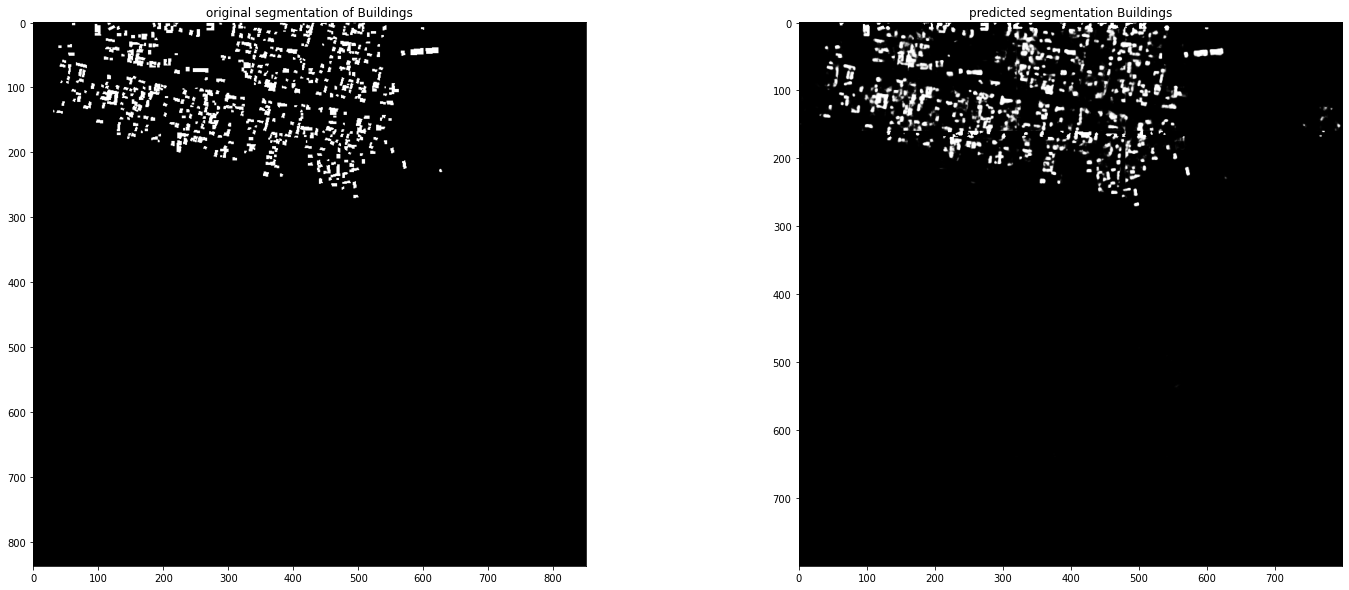

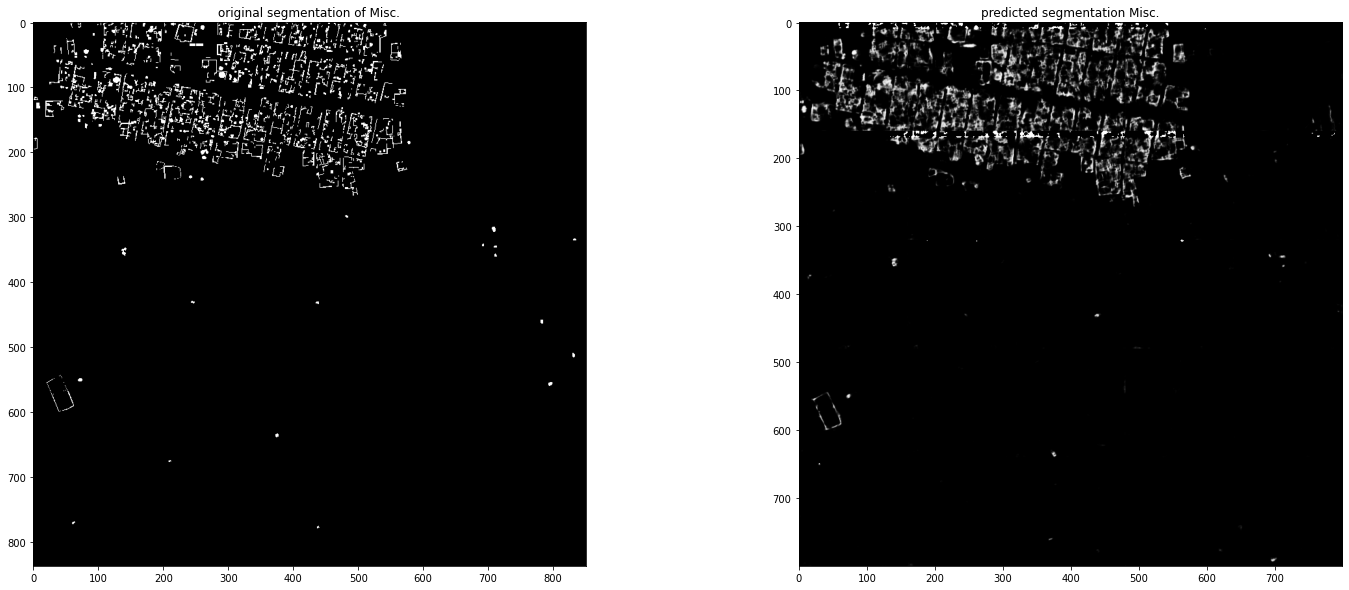

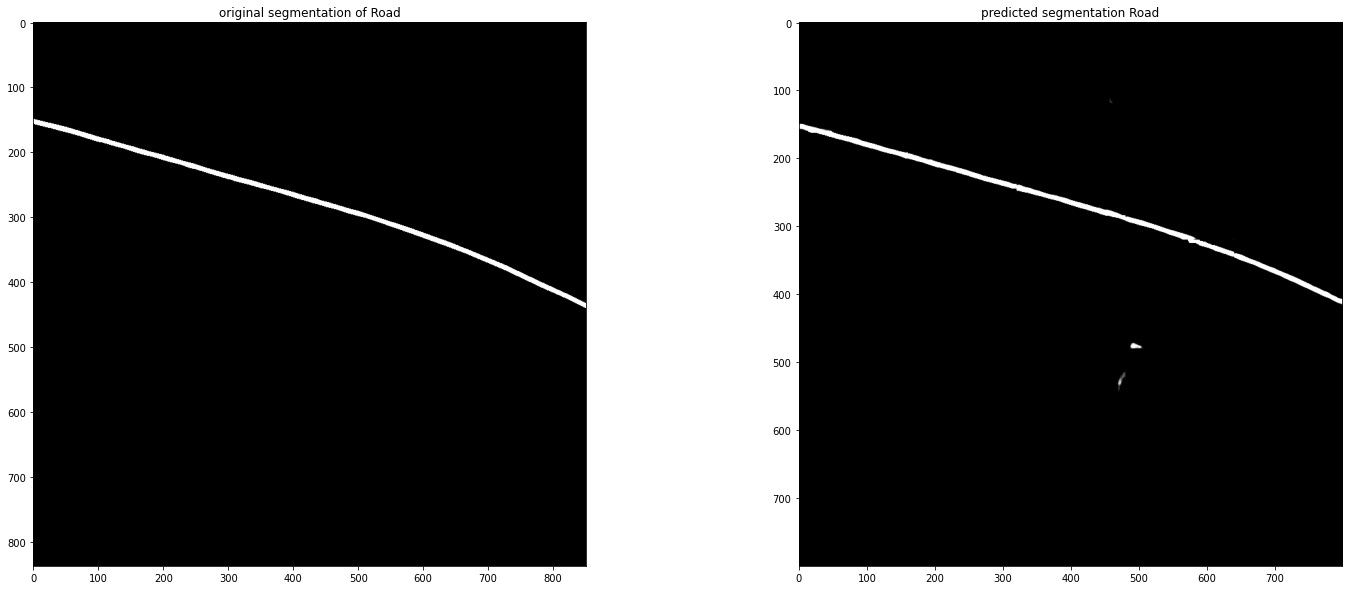

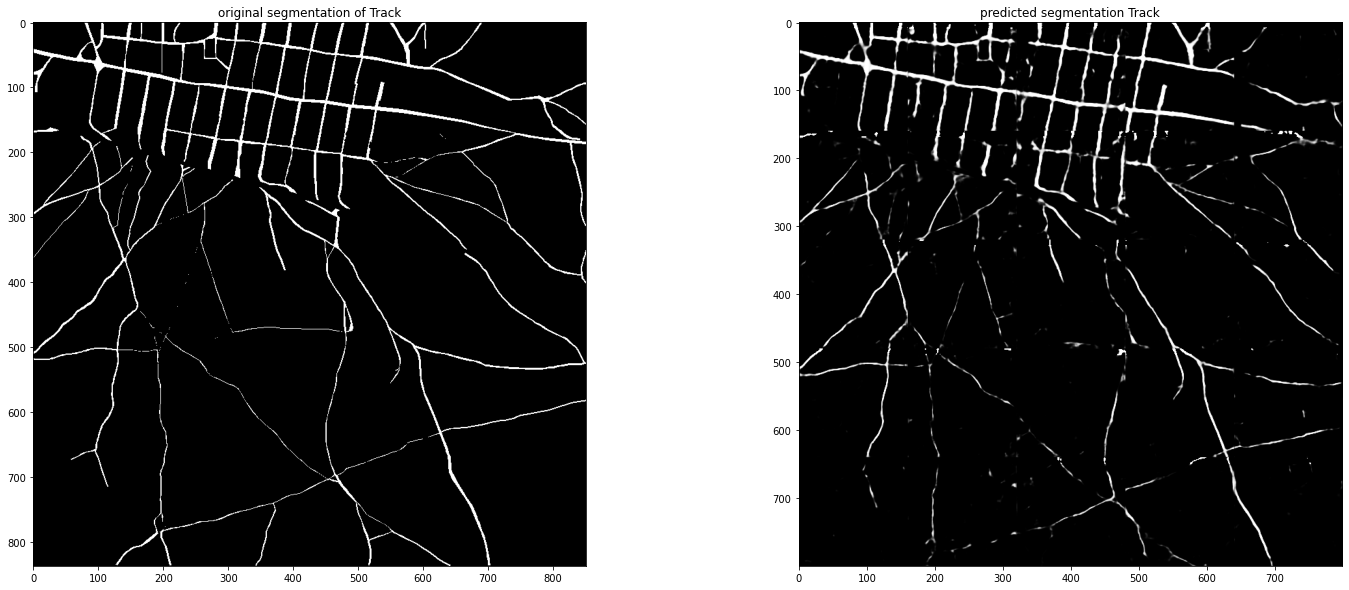

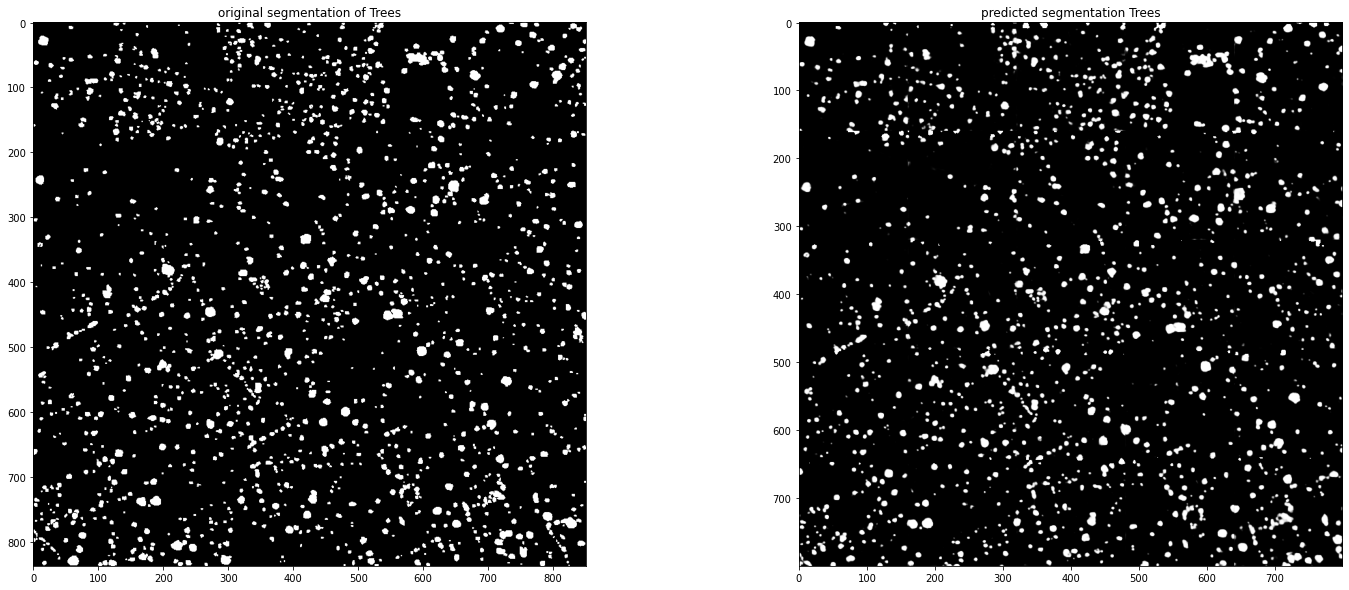

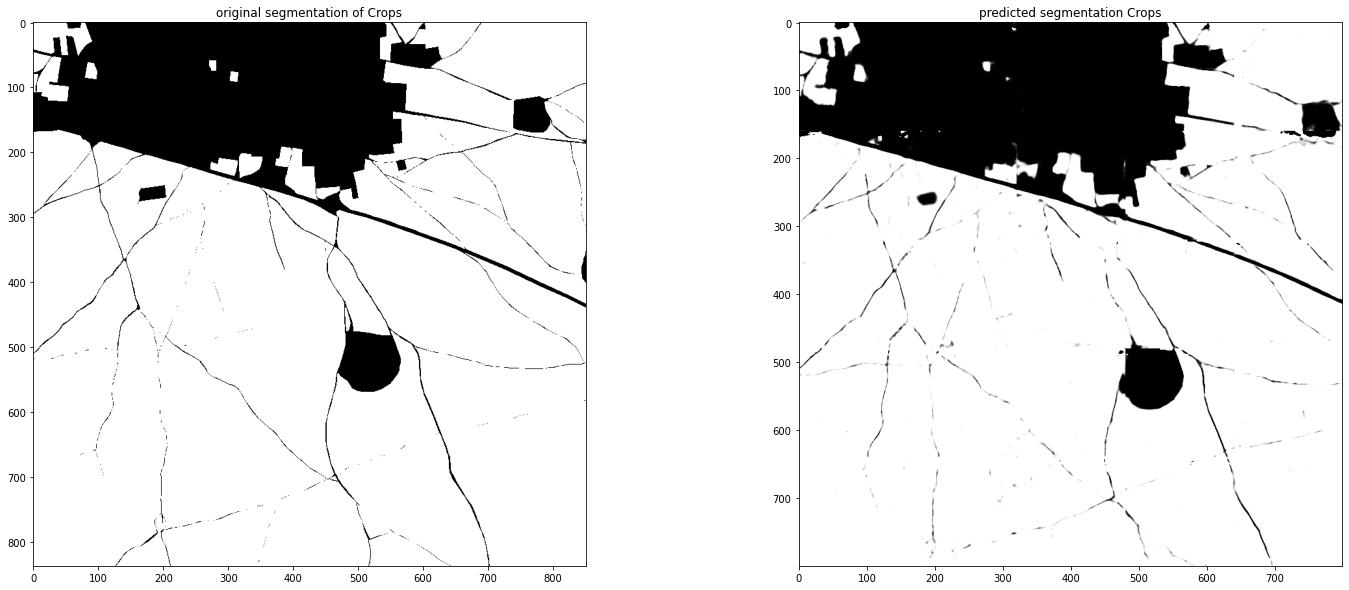

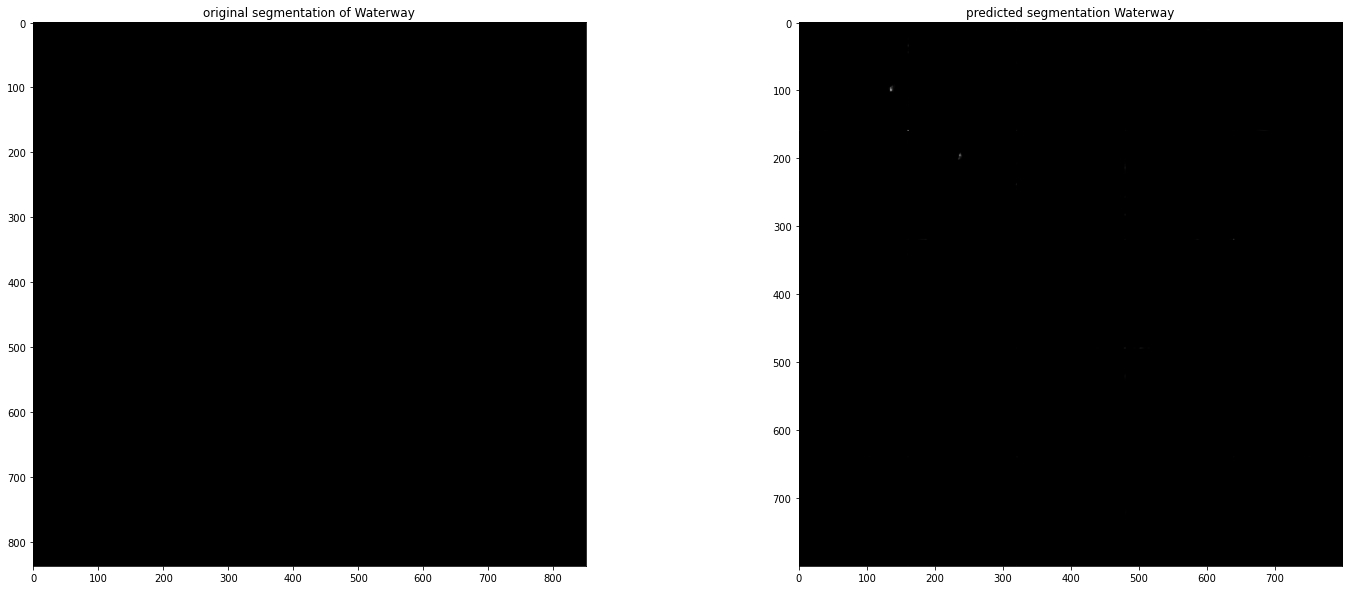

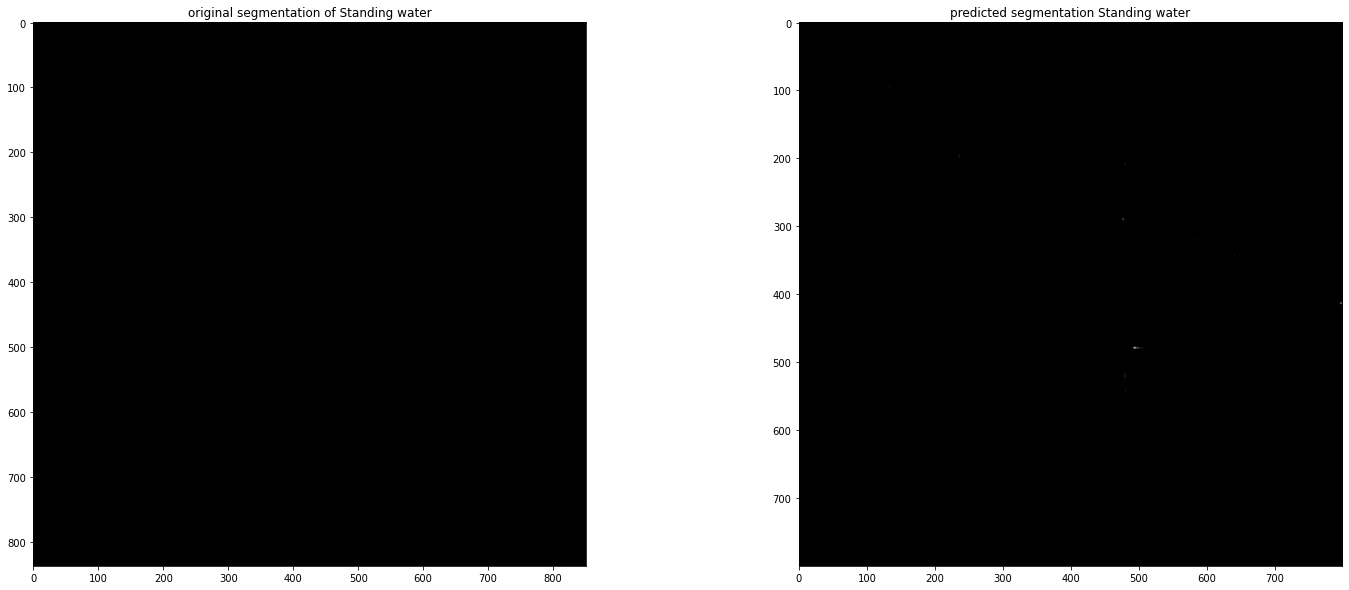

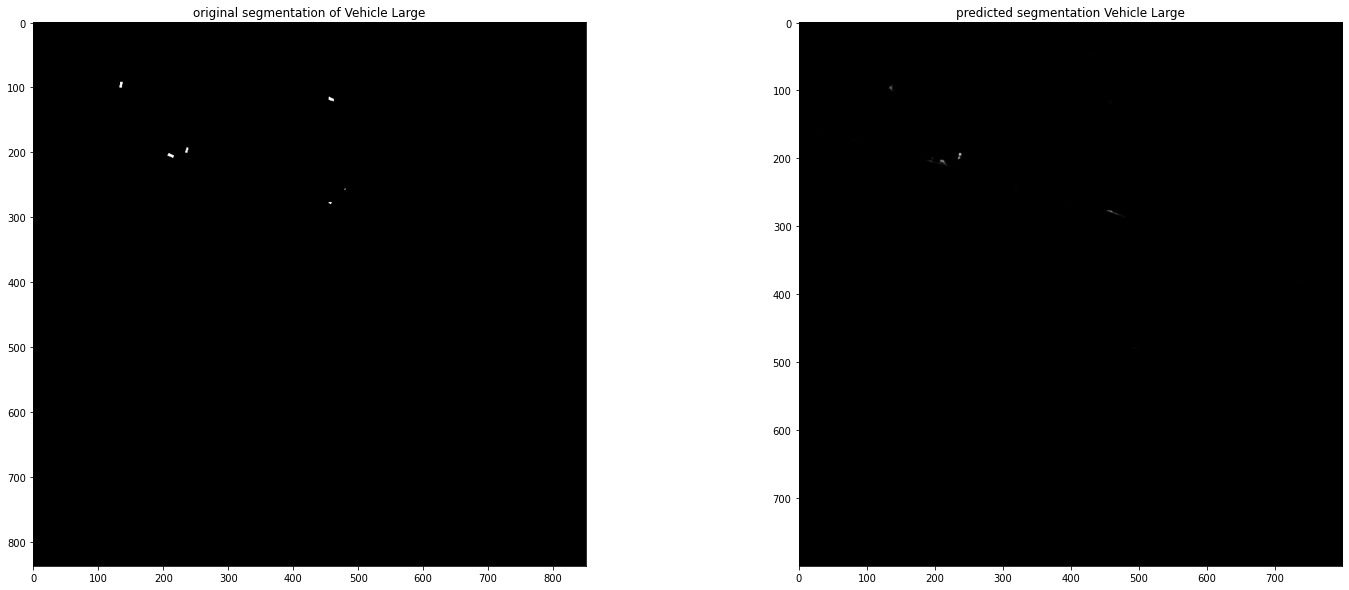

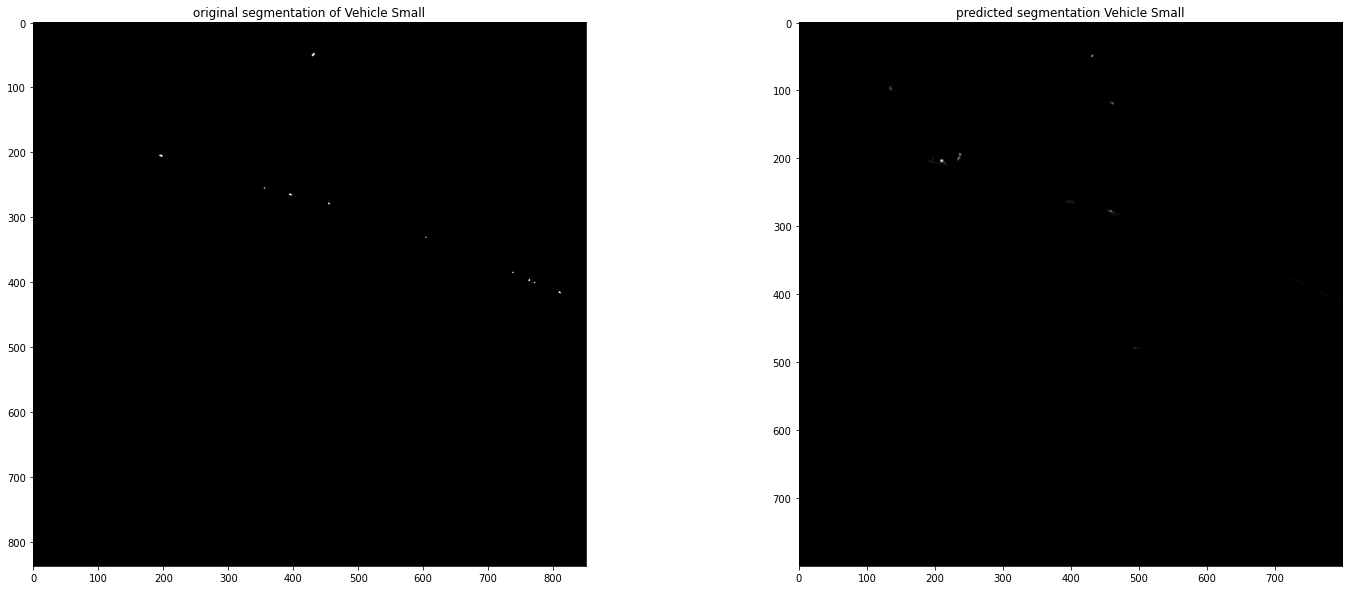

In [38]:
from patchify import unpatchify

unpatch = np.zeros((5,5,160,160,10))
c = 0
for i in range(5):
    for j in range(5):
        unpatch[i,j,:,:,:] = pred_mask[c,:,:,:]
        c+=1
unpatched_prediction = unpatchify(np.expand_dims(unpatch,axis=2),(800,800,10))
for ele in range(10): #going through prediction of all classes
    fig,ax = plt.subplots(1,2,figsize=(25,10))
    ax[0].imshow(mask[:,:,ele], cmap=plt.get_cmap('gray'))
    ax[1].imshow(unpatched_prediction[:,:,ele], cmap=plt.get_cmap('gray'))
    ax[0].set_title('original segmentation of '+classes[ele])
    ax[1].set_title('predicted segmentation '+classes[ele])
    plt.show()